In [1]:
## Import Packages
import os
import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from lofo import LOFOImportance, Dataset, plot_importance

D:\Anaconda\envs\tfenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Data Preparations
df_nominal = pd.read_csv("combined_dataset.csv")  # Nominal events on BA classifier
df_fixedz = pd.read_csv("combined_dataset_z+1.csv")

In [3]:
X_train = df_nominal.drop(columns=['event', 'label']).values
y_train = df_nominal['label'].values

# Test on z fixed data
X_test = df_fixedz.drop(columns=['event', 'label', 'z']).values
y_test = df_fixedz['label'].values

print('Training sets size:', X_train.shape)
print('Test sets size:', X_test.shape)

## Standardize the data
scaler = StandardScaler()
scaler.fit(X_train)  # Fit only on training set
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training sets size: (199504, 14)
Test sets size: (199504, 14)


In [4]:
## Define Keras Model
model = Sequential()
model.add(Input(shape=(14,)))  
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [5]:
## Compile the Keras Model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Fit the Keras Model !!!(May use classweight for different data size)
history = model.fit(
    X_train_scaled,  # Input (standarlized) features
    y_train,   # Target labels (0 or 1)
    epochs=50,  # Number of full passes over the training data
    batch_size=10,  # number of samples per gradient update
    verbose=2  # One line per epochs 
)

Epoch 1/50
19951/19951 - 26s - 1ms/step - accuracy: 0.7382 - loss: 0.5358
Epoch 2/50
19951/19951 - 41s - 2ms/step - accuracy: 0.7478 - loss: 0.5182
Epoch 3/50
19951/19951 - 26s - 1ms/step - accuracy: 0.7494 - loss: 0.5150
Epoch 4/50
19951/19951 - 25s - 1ms/step - accuracy: 0.7500 - loss: 0.5136
Epoch 5/50
19951/19951 - 26s - 1ms/step - accuracy: 0.7510 - loss: 0.5125
Epoch 6/50
19951/19951 - 40s - 2ms/step - accuracy: 0.7513 - loss: 0.5117
Epoch 7/50
19951/19951 - 26s - 1ms/step - accuracy: 0.7514 - loss: 0.5113
Epoch 8/50
19951/19951 - 41s - 2ms/step - accuracy: 0.7521 - loss: 0.5110
Epoch 9/50
19951/19951 - 42s - 2ms/step - accuracy: 0.7519 - loss: 0.5106
Epoch 10/50
19951/19951 - 26s - 1ms/step - accuracy: 0.7522 - loss: 0.5106
Epoch 11/50
19951/19951 - 26s - 1ms/step - accuracy: 0.7519 - loss: 0.5103
Epoch 12/50
19951/19951 - 26s - 1ms/step - accuracy: 0.7527 - loss: 0.5102
Epoch 13/50
19951/19951 - 41s - 2ms/step - accuracy: 0.7528 - loss: 0.5100
Epoch 14/50
19951/19951 - 26s - 1m

In [6]:
## Make predictions on the test set
y_pred_probs = model.predict(X_test_scaled)  # Use "Test" dataset for prediction
y_pred_labels = (y_pred_probs > 0.5).astype(int)  # Convert probabilities into class label (>0.5 -> 1, <0.5 -> 0) 

## Evaluate the model accuracy on test dataset
accuracy = accuracy_score(y_test, y_pred_labels)
print(f'Test Accuracy: {accuracy:.4f}')

6235/6235 ━━━━━━━━━━━━━━━━━━━━ 5s 743us/step
Test Accuracy: 0.7317


In [7]:
# Data Storage
MODEL_NAME = "BA"        
Z_TEST = 1.0             # Current fixed z value

# Output path
out_dir = f"outputs/{MODEL_NAME}/z_{Z_TEST:+.1f}"
os.makedirs(out_dir, exist_ok=True)

# Save results
np.savez_compressed(
    os.path.join(out_dir, "preds.npz"),
    y_test=y_test.astype(int),
    y_score=y_pred_probs.ravel().astype(float)
)

# Save ROC results
fpr, tpr, thr = roc_curve(y_test, y_pred_probs.ravel())
rocAUC = auc(fpr, tpr)
np.savez_compressed(
    os.path.join(out_dir, "roc.npz"),
    fpr=fpr, tpr=tpr, thr=thr, auc=np.array([rocAUC], dtype=float)
)

print(f"Result saved to {out_dir}, AUC={rocAUC:.3f}")

结果已保存到 outputs/BA/z_+1.0, AUC=0.811


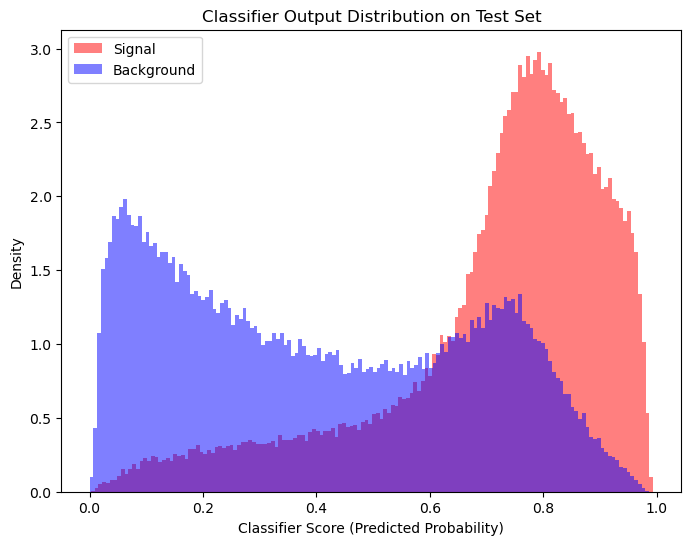

In [7]:
## Plot classfier output distribution
signal_scores = y_pred_probs[y_test == 1]
background_scores = y_pred_probs[y_test == 0]

# Create histogram
plt.figure(figsize=(8, 6))
plt.hist(signal_scores, bins=150, alpha=0.5, label='Signal', density=True, color='red')
plt.hist(background_scores, bins=150, alpha=0.5, label='Background', density=True, color='blue')

# Add labels and title
plt.xlabel('Classifier Score (Predicted Probability)')
plt.ylabel('Density')
plt.title('Classifier Output Distribution on Test Set')
plt.legend()
plt.savefig("Score_histogram_BA_Z=0.pdf")
plt.show()

6235/6235 ━━━━━━━━━━━━━━━━━━━━ 4s 636us/step


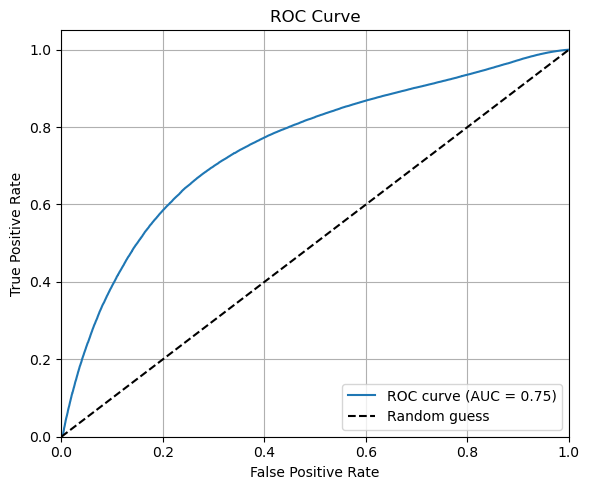

In [8]:
## Plot ROC curve, calculate AUC
# Acquire prediction probability on signals
y_pred_probs = model.predict(X_test_scaled).ravel()

# Calculate FPR, TPR and corresponding thersholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')  # Show random model line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

PermutationExplainer explainer: 501it [00:35, 12.82it/s]                                                               
C:\Users\ROG\AppData\Local\Temp\ipykernel_26044\2645478770.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_test_sample, feature_names=feature_names)


(500, 14)


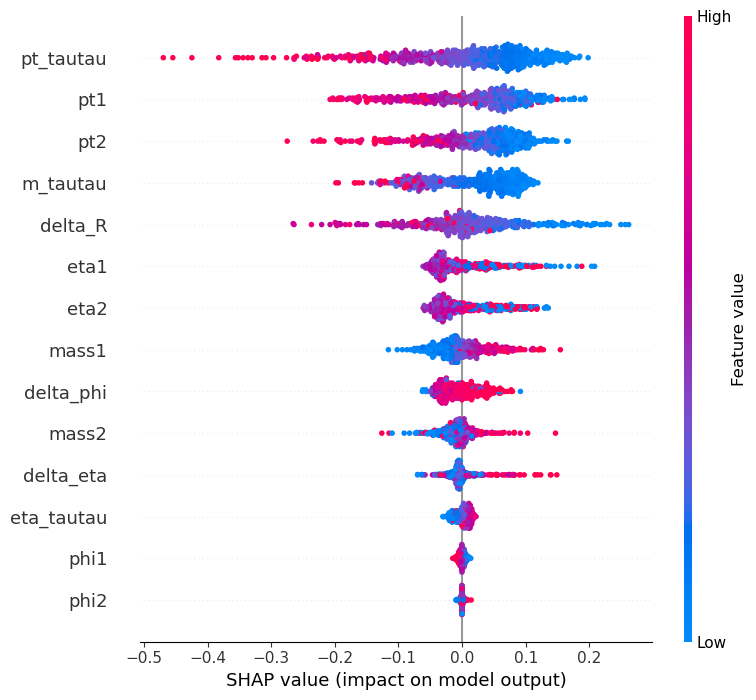

In [9]:
## Evaluate Importance of Feature
feature_names = [
    "pt1", "eta1", "phi1", "mass1",
    "pt2", "eta2", "phi2", "mass2",
    "delta_eta", "delta_phi", "delta_R",
    "m_tautau", "pt_tautau", "eta_tautau"
]

# Take sample from train and test for SHAP evaluation
X_train_sample = X_train_scaled[:100]
X_test_sample = X_test_scaled[:500]

# Compute SHAP explainer
explainer = shap.Explainer(model, X_train_sample)
shap_values = explainer(X_test_sample)

# Check dimensions
print(shap_values.shape)

# SHAP summary plot
shap.summary_plot(shap_values.values, X_test_sample, feature_names=feature_names)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:40<00:00,  2.87s/it]


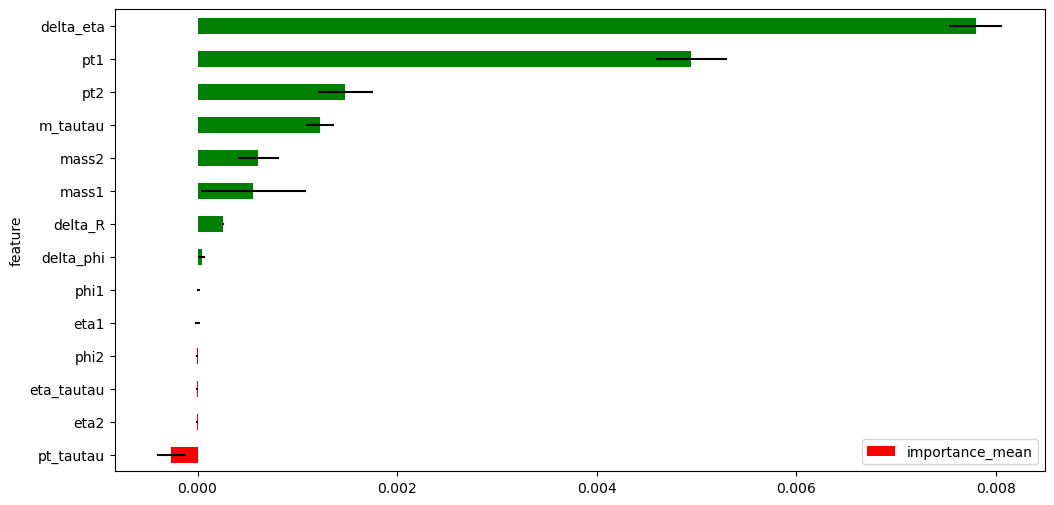

In [10]:
## Compute LOFO: Check importance of features
feature_names = [
    "pt1", "eta1", "phi1", "mass1",
    "pt2", "eta2", "phi2", "mass2",
    "delta_eta", "delta_phi", "delta_R",
    "m_tautau", "pt_tautau", "eta_tautau"
]

# Reconstruct DataFrame（exclude z and event）
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_train_df["label"] = y_train

# Compute lofo dataset
lofo_dataset = Dataset(df=X_train_df, target="label", features=feature_names)

# Define the lofo model
lofo_model = LogisticRegression(max_iter=1000, solver="liblinear")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calculate LOFO importance
lofo_imp = LOFOImportance(lofo_dataset, model=lofo_model, cv=cv, scoring="roc_auc")
importance_df = lofo_imp.get_importance()

plot_importance(importance_df, figsize=(12, 6))
plt.savefig("lofo_importance_baseline.pdf", bbox_inches='tight')

In [11]:
## Save Results
np.save("y_test_baseline.npy", y_test)
np.save("y_pred_probs_baseline.npy", y_pred_probs)